In [ ]:
!pip install mne
!pip install git+https://github.com/forrestbao/pyeeg.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 35.5 MB/s eta 0:00:00
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-cepc95a0
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-cepc95a0
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28112 sha256=77ae645ce6360a53b22402d5ee853d625fe2caeecb23eb5fc3afffdca870d1d8
  Stored in directory: /tmp/pip-ephem-wheel-cache-x3jf_gd4/wheels/a8/c4/1a/cee09dcc12a11620066d35ace42e3c1e3bfbcc1db3a0ce7788
Successfully built pyeeg


In [ ]:
######################################################################
# EEG epilepsy classification
# preprocessing: convert one-hour or else individual edf into csv and
# with feature extractions.

import os
import glob
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyeeg
from scipy.stats import kurtosis, skew
from scipy.signal import argrelextrema, welch
from scipy.integrate import cumtrapz
import statistics
import time

### Functions

def eeg_features(data):
    data = np.asarray(data)
    res  = np.zeros([22])                                                         # hold res number of features
    Kmax = 5
    Band = [1,5,10,15,20,25]
    Fs   = 256
    power, power_ratio = pyeeg.bin_power(data, Band, Fs)
    f, P = welch(data, fs=Fs, window='hann', noverlap=0, nfft=int(256.))          # Signal power spectrum
    area_freq = cumtrapz(P, f, initial=0)                                         # AUC of the signal power spectrum
    res[0] = np.sqrt(np.sum(np.power(data, 2)) / data.shape[0])                   # amplitude RMS
    res[1] = statistics.stdev(data)**2                                            # variance
    res[2] = kurtosis(data)                                                       # kurtosis
    res[3] = skew(data)                                                           # skewness
    res[4] = max(data)                                                            # max amplitude
    res[5] = min(data)                                                            # min amplitude
    res[6] = len(argrelextrema(data, np.greater)[0])                              # number of local extrema or peaks
    res[7] = ((data[:-1] * data[1:]) < 0).sum()                                   # number of zero crossings
    res[8] = pyeeg.hfd(data, Kmax)                                                # Higuchi Fractal Dimension
    res[9] = pyeeg.pfd(data)                                                      # Petrosian Fractal Dimension
    res[10] = pyeeg.hurst(data)                                                   # Hurst exponent
    res[11] = pyeeg.spectral_entropy(data, Band, Fs, Power_Ratio=power_ratio)     # spectral entropy (1.21s)
    res[12] = area_freq[-1]                                                       # total power
    res[13] = f[np.where(area_freq >= res[12] / 2)[0][0]]                         # median frequency
    res[14] = f[np.argmax(P)]                                                     # peak frequency
    res[15], res[16] = pyeeg.hjorth(data)                                         # Hjorth mobility and complexity
    res[17] = power_ratio[0]
    res[18] = power_ratio[1]
    res[19] = power_ratio[2]
    res[20] = power_ratio[3]
    res[21] = power_ratio[4]

    return (res)


def eeg_preprocessing(file, seizures, epoch_length = 10, step_size = 1, start_time = 0):
    start = time.time()

    # reading in data
    raw = mne.io.read_raw_edf(file)

    # apply filterbank
    raw = raw.load_data().filter(l_freq=0.25, h_freq=25)
    channels = raw.ch_names                                                       # column names

    # Divide into epochs, creating epochs
    res = []
    while start_time <= max(raw.times) + 0.01 - epoch_length:                     # max(raw.times) = 3600
        #a Python list that stores the calculated features and label for each epoch of EEG data.
        features = []
        start, stop = raw.time_as_index([start_time, start_time + epoch_length])
        # The [0] extracts the actual EEG data, discarding any additional
        # metadata or information that might be included in the segment.
        temp = raw[:, start:stop][0]

        # start time as ID
        features.append(start_time)

        # features
        for i in range(23):   # 23 iterations.
            features.extend(eeg_features(temp[i]).tolist())

        # seizure flag for y
        if filename in seizures:  # if file has seizure
            for seizure in seizures[filename]:
                if start_time > seizure[0] and start_time < seizure[1]:
                    features.append(1)
                elif start_time + epoch_length > seizure[0] and start_time + epoch_length < seizure[1]:
                    features.append(1)
                else:
                    features.append(0)
        else:
            features.append(0)

        res.append(features)
        start_time += step_size
        print("Section ", str(len(res)), "; start: ", start, " ; stop: ", stop)

    # formatting
    feature_names = ["rms", "variance", "kurtosis", "skewness", "max_amp", "min_amp", "n_peaks", "n_crossings",
        "hfd", "pfd", "hurst_exp", "spectral_entropy", "total_power", "median_freq", "peak_freq",
        "hjorth_mobility", "hjorth_complexity", "power_1hz", "power_5hz", "power_10hz", "power_15hz", "power_20hz"]

    column_names = ["start_time"]
    for channel in channels:
        for name in feature_names:
            column_names.append(channel + "_" + name)
    column_names.append("seizure")

    res = pd.DataFrame(res, columns=column_names)

    end = time.time()
    print("Finished preprocessing ", file, f" took {(end - start) / 60} minutes")
    return res

# EEG edf files are at idrive.google.  For colab to access the edf files,
# mount google mydrive.

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from tensorflow import keras

def ANN(input_shape):
    # Define the ANN model
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='adam', loss='binary_crossentropy')

    return model

In [ ]:
######################################################################
# EEG epilepsy classification
# classification algorithms

from statistics import mean
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier

def PCA_process(X_train, X_test):
    pca = PCA(n_components = 50)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    print("PCA explained variance is: ", np.sum(pca.explained_variance_ratio_))
    return X_train, X_test


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confusion_matrix_plot(y_test, pred):
  # Confusion matrix
  conf_mx = confusion_matrix(y_test, pred)
  # Create a display object for visualization
  cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_mx, display_labels=["Non-Seizure", "Seizure"])
  # Plot the confusion matrix
  cm_display.plot(cmap="Blues", values_format=".0f")
  plt.title("Confusion Matrix")
  plt.show()
  TN = conf_mx[0,0]
  FP = conf_mx[0,1]
  FN = conf_mx[1,0]
  TP = conf_mx[1,1]
  print ('TN: ', TN)
  print ('FP: ', FP)
  print ('FN: ', FN)
  print ('TP: ', TP)

In [ ]:
def training(pca_flag = False):

  # get all the subjects/patients' file information
  folder = r"/content/drive/MyDrive/ELEC509/ELEC 509-Final Project Data"
  subjects = ["chb01"]
  #subjects = ["chb01", "chb02", "chb03"]

  training_csv_file_names_without_path = [file for file in os.listdir(folder) if file.endswith(".csv")]

  # get dataset file names prfixed with absolute path
  training_csv_files = [folder+'/'+file for file in os.listdir(folder) if file.endswith(".csv")]

  output_files = []

  print(f"{len(training_csv_files)} file(s) to be trained using the following models:\n{training_csv_files}")


  #for input_file, subject in zip(training_csv_files, subjects):
  for input_file, input_file_no_path in zip(training_csv_files, training_csv_file_names_without_path):
      # prepare data
      data = pd.read_csv(input_file)
      X = data.loc[:, data.columns != "seizure"]
      X = X.loc[:, X.columns != "start_time"]
      X = X.loc[:, X.columns != "file ID"]
      Y = np.asarray(data['seizure'])
      feature_names = X.columns.tolist()
      print('The number of samples for the non-seizure class is:', Y.shape[0])
      print('The number of samples for the seizure class is:', np.sum(Y))

      ### preprocessing

      # check zero variance features
      thresholder = VarianceThreshold(threshold=0)
      print("Variables Kept after removing features with 0 variance: ", thresholder.fit_transform(X).shape[1])

      # highly correlated features
      corr = abs(X.corr())
      upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
      cols = [column for column in upper.columns if any(upper[column] < 0.9)]
      print("Variables Kept after removing features with corr > 0.9: ", len(cols))

      # normalize features
      X = preprocessing.normalize(X)

      # split into testing and training
      X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)
      print('The number of samples for the non-seizure class in training is:', y_train.shape[0])
      print('The number of samples for the seizure class in training is:', np.sum(y_train))
      print('The number of samples for the non-seizure class in testing is:', y_test.shape[0])
      print('The number of samples for the seizure class in testing is:', np.sum(y_test))

      # PCA flag

      if pca_flag == True:
          PCA_process(X_train, X_test)

      input_shape = X_train.shape[1]

      # Modeling
      if pca_flag == True:
        names = ["PCA_KNN", "PCA_ANN"]
      else:
        names = ["KNN", "ANN"]

      models = [
          KNeighborsClassifier(2), ANN(input_shape)
          ]

      result = []
      for name, model in zip(names, models):

          if name == "ANN" or name == "PCA_ANN":
              X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
              X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
              input_shape = X_train.shape[1]

          # cross validation
          kf = KFold(n_splits=5)
          accuracy, recall, FPR, precision, f1_score = [], [], [], [], []
          for train, test in kf.split(X_train):
              model.fit(X_train[train, :], y_train[train])
              pred = model.predict(X_train[test])
              if name == "ANN" or name == "PCA_ANN":
                  # Predict probabilities and convert to binary predictions
                  pred = (pred > 0.5).astype(int)                                   # Convert probabilities to 0 or 1
              tn, fp, fn, tp = confusion_matrix(y_train[test], pred).ravel()
              accuracy.append((tp + tn)/(tn + fp + fn + tp))
              precision.append(tp / (tp + fp))
              recall.append(tp / (tp + fn))                                         # True positive rate - recall
              FPR.append(fp / (fp + tn))                                            # False positive rate - probability of false alarm
              f1_score.append(2 * (precision[-1] * recall[-1]) / (precision[-1] + recall[-1]))
              print(confusion_matrix(y_train[test], pred))
              confusion_matrix_plot(y_train[test], pred)

          # test validation
          start = time.time()
          model.fit(X_train, y_train)
          pred = model.predict(X_test)
          if name == "ANN" or name == "PCA_ANN":
              # Predict probabilities and convert to binary predictions
              pred = (pred > 0.5).astype(int)                                        # Convert probabilities to 0 or 1
          tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
          test_accuracy = ((tp + tn)/(tn + fp + fn + tp))
          test_precision = (tp / (tp + fp))
          test_recall = (tp / (tp + fn))
          test_FPR = (fp / (fp + tn))
          test_f1_score = (2 * (test_precision * test_recall) / (test_precision + test_recall))
          end = time.time()
          hours, rem = divmod(end-start, 3600)
          minutes, seconds = divmod(rem, 60)
          print(name)
          print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
          print(confusion_matrix(y_test, pred))
          confusion_matrix_plot(y_test, pred)

          # record results
          result.append ({
                      'model': name,
                      'cv accuracy': mean(accuracy),
                      'cv recall': mean(recall),
                      'cv precision': mean(precision),
                      'cv FPR': mean(FPR),
                      'cv f1 score': mean(f1_score),
                      'test accuracy': test_accuracy,
                      'test recall': test_recall,
                      'test precision': test_precision,
                      'test FPR': test_FPR,
                      'test f1 score': test_f1_score
                  })

      final = pd.DataFrame.from_dict(result)

      output_file_name = input_file_no_path.replace(".csv", "_results.csv")

      subfolder_name = "Results"
      output_file_folder_path = os.path.join(folder, subfolder_name)

      if not os.path.exists(output_file_folder_path):
        os.makedirs(output_file_folder_path)

      output_file = os.path.join(output_file_folder_path, output_file_name)
      final.to_csv(output_file, mode='a', index=False, header=False)

      print(final)
      print(f"**** Model Training is done. The result is in {output_file} ****\n")

3 file(s) to be trained using the following models:
['/content/drive/MyDrive/ELEC509/ELEC 509-Final Project Data/chb01.csv', '/content/drive/MyDrive/ELEC509/ELEC 509-Final Project Data/chb02.csv', '/content/drive/MyDrive/ELEC509/ELEC 509-Final Project Data/chb03.csv']
The number of samples for the non-seizure class is: 145610
The number of samples for the seizure class is: 505
Variables Kept after removing features with 0 variance:  506
Variables Kept after removing features with corr > 0.9:  504
The number of samples for the non-seizure class in training is: 116488
The number of samples for the seizure class in training is: 400
The number of samples for the non-seizure class in testing is: 29122
The number of samples for the seizure class in testing is: 105
PCA explained variance is:  0.9897970115803916


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[[23193     0]
 [   35    70]]


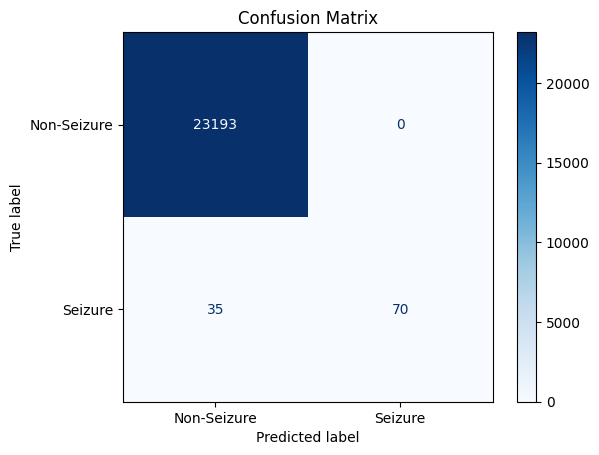

TN:  23193
FP:  0
FN:  35
TP:  70
[[23224     1]
 [   17    56]]


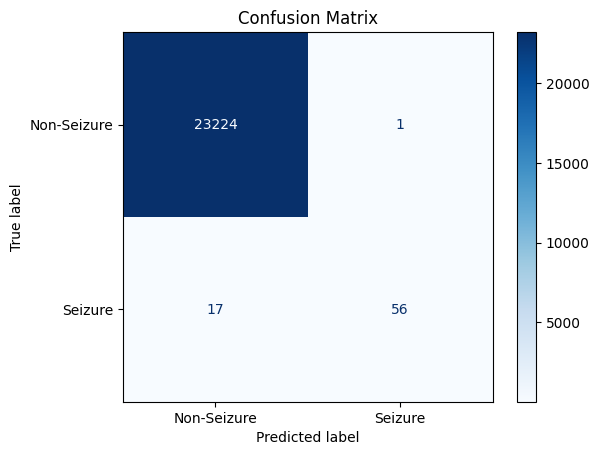

TN:  23224
FP:  1
FN:  17
TP:  56
[[23227     2]
 [   22    47]]


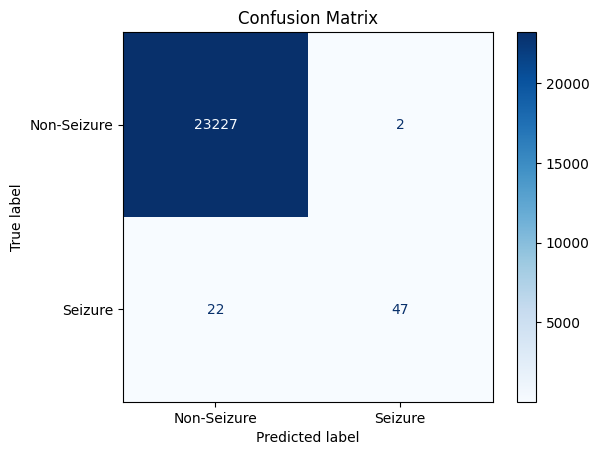

TN:  23227
FP:  2
FN:  22
TP:  47
[[23226     0]
 [   15    56]]


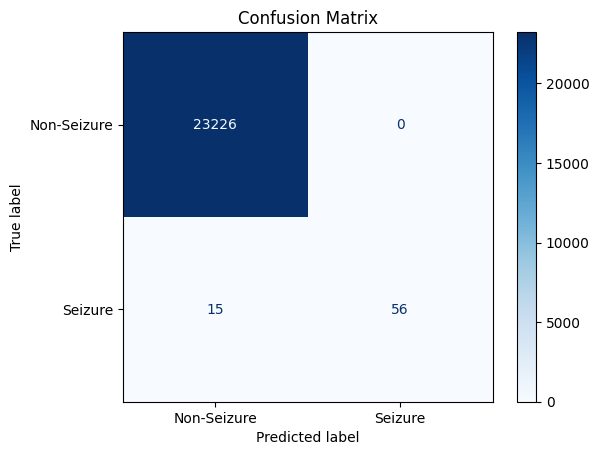

TN:  23226
FP:  0
FN:  15
TP:  56
[[23213     2]
 [   28    54]]


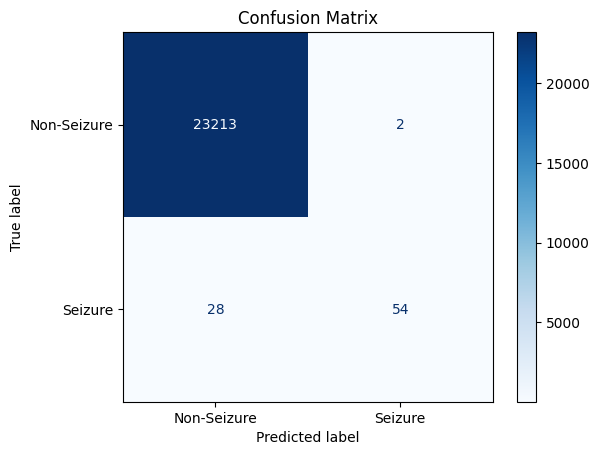

TN:  23213
FP:  2
FN:  28
TP:  54
PCA_KNN
00:02:23.18
[[29016     1]
 [   22    83]]


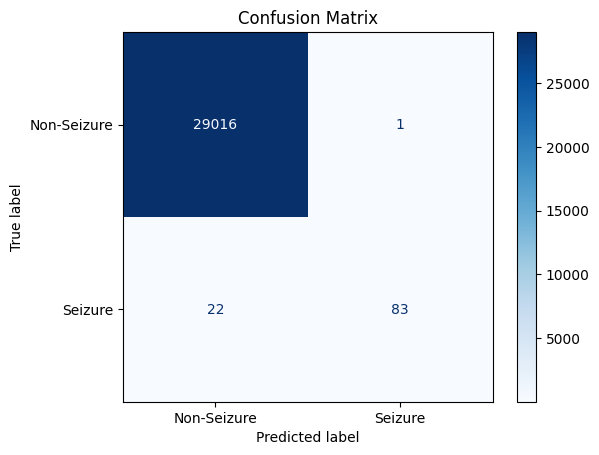

TN:  29016
FP:  1
FN:  22
TP:  83
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0380
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<ipython-input-120-0985fa61fe7c>:88: RuntimeWarning: invalid value encountered in scalar divide
  precision.append(tp / (tp + fp))


[[23193     0]
 [  105     0]]


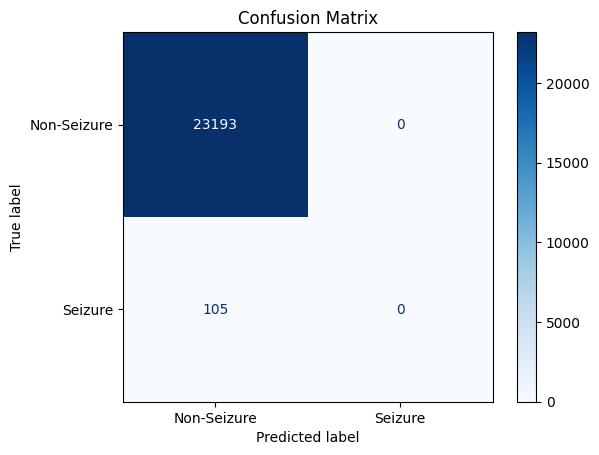

TN:  23193
FP:  0
FN:  105
TP:  0
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0082
729/729 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[[23215    10]
 [   24    49]]


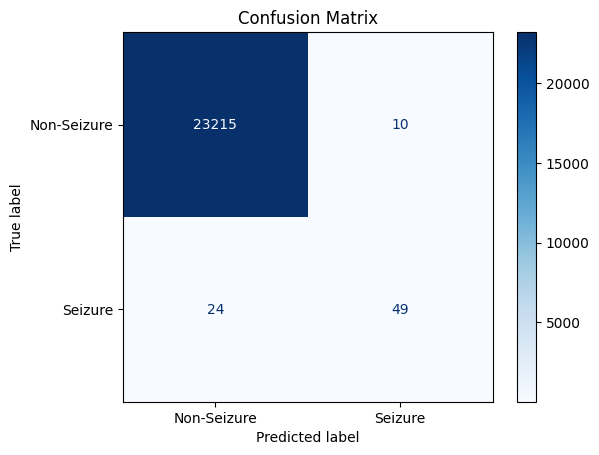

TN:  23215
FP:  10
FN:  24
TP:  49
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0056
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
[[23210    19]
 [   16    53]]


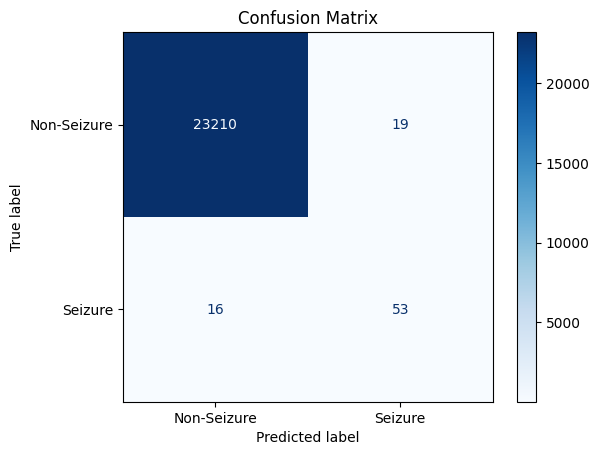

TN:  23210
FP:  19
FN:  16
TP:  53
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0058
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
[[23221     5]
 [   10    61]]


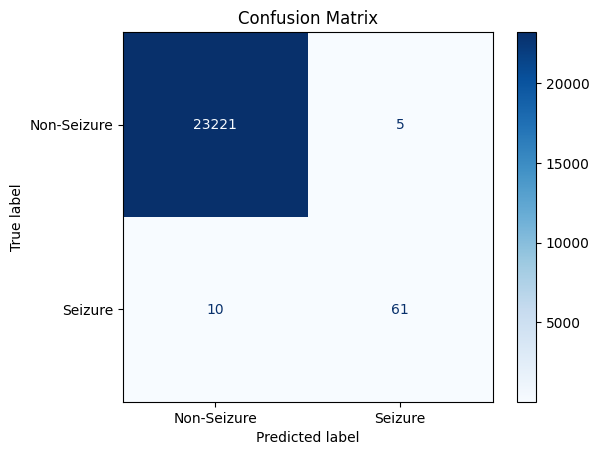

TN:  23221
FP:  5
FN:  10
TP:  61
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0047
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
[[23202    13]
 [   14    68]]


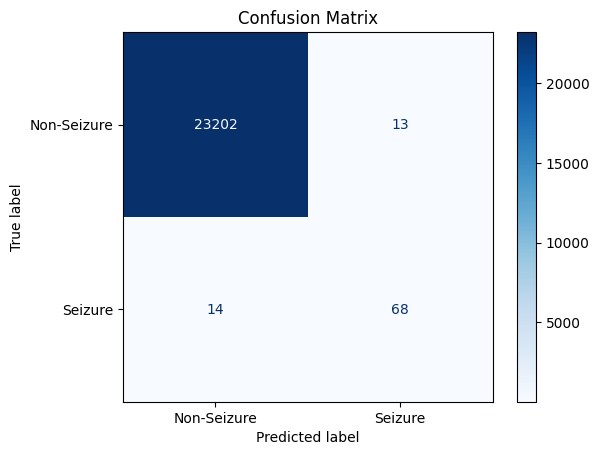

TN:  23202
FP:  13
FN:  14
TP:  68
3641/3641 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.0038
911/911 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
PCA_ANN
00:00:22.44
[[29017     0]
 [   41    64]]


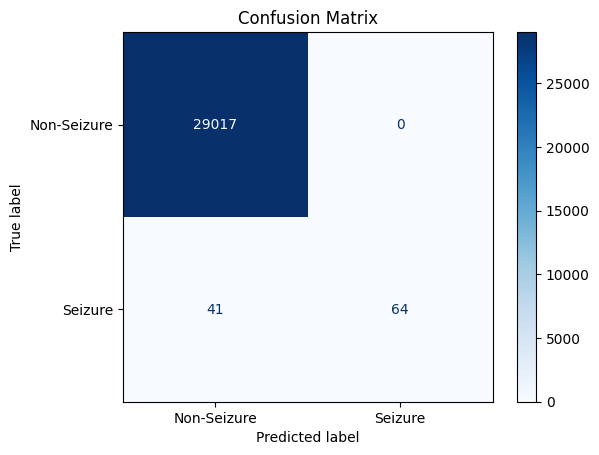

TN:  29017
FP:  0
FN:  41
TP:  64
     model  cv accuracy  cv recall  cv precision    cv FPR  cv f1 score  \
0  PCA_KNN     0.998953   0.712444      0.981185  0.000043     0.824529   
1  PCA_ANN     0.998146   0.625554           NaN  0.000405          NaN   

   test accuracy  test recall  test precision  test FPR  test f1 score  
0       0.999210     0.790476        0.988095  0.000034       0.878307  
1       0.998592     0.609524        1.000000  0.000000       0.757396  
**** Model Training is done. The result is in /content/drive/MyDrive/ELEC509/ELEC 509-Final Project Data/Results/chb01_results.csv ****

The number of samples for the non-seizure class is: 126635
The number of samples for the seizure class is: 207
Variables Kept after removing features with 0 variance:  506
Variables Kept after removing features with corr > 0.9:  505
The number of samples for the non-seizure class in training is: 101308
The number of samples for the seizure class in training is: 155
The number of sa

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[[20225     0]
 [    1    36]]


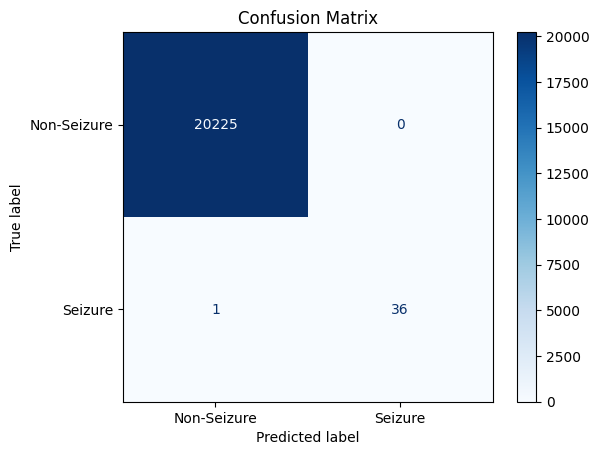

TN:  20225
FP:  0
FN:  1
TP:  36
[[20229     0]
 [    6    27]]


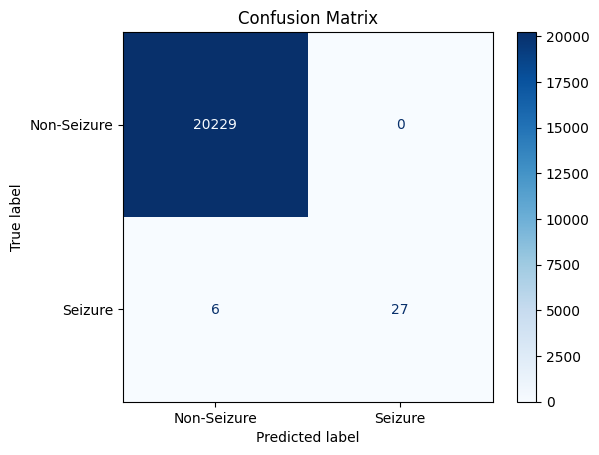

TN:  20229
FP:  0
FN:  6
TP:  27
[[20230     0]
 [    5    27]]


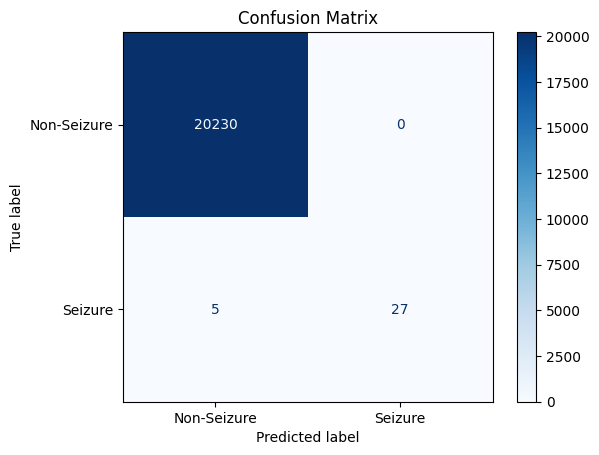

TN:  20230
FP:  0
FN:  5
TP:  27
[[20234     1]
 [    1    25]]


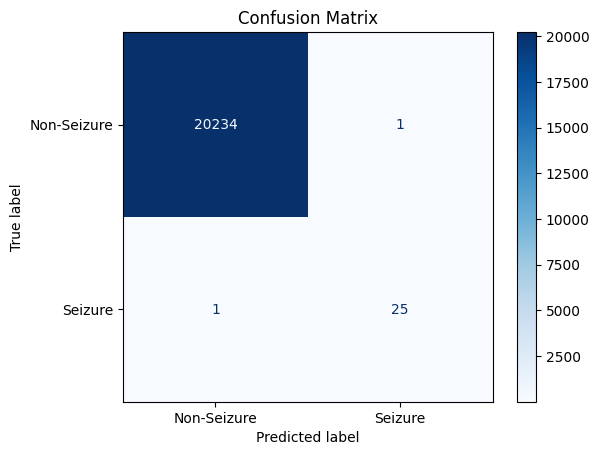

TN:  20234
FP:  1
FN:  1
TP:  25
[[20234     0]
 [    1    26]]


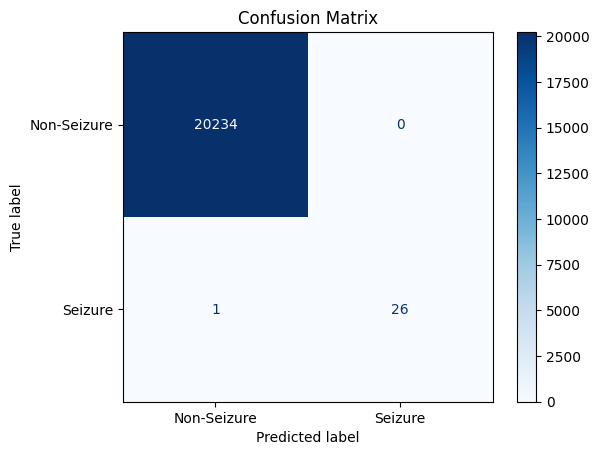

TN:  20234
FP:  0
FN:  1
TP:  26
PCA_KNN
00:01:47.29
[[25275     0]
 [    6    46]]


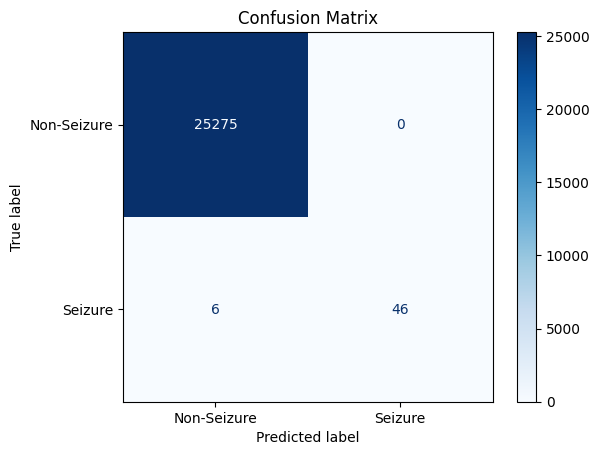

TN:  25275
FP:  0
FN:  6
TP:  46
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0385
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


<ipython-input-120-0985fa61fe7c>:88: RuntimeWarning: invalid value encountered in scalar divide
  precision.append(tp / (tp + fp))


[[20225     0]
 [   37     0]]


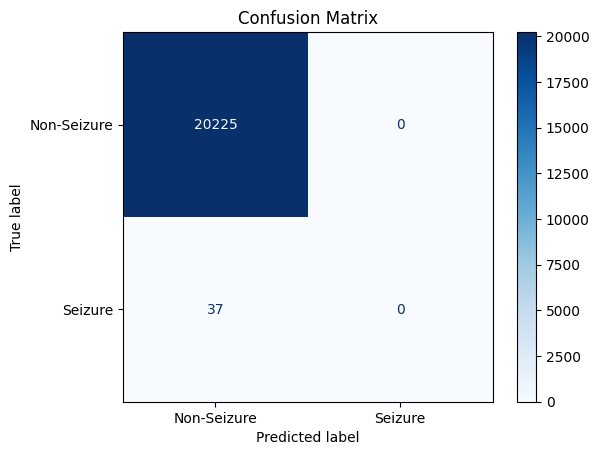

TN:  20225
FP:  0
FN:  37
TP:  0
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0089
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


<ipython-input-120-0985fa61fe7c>:88: RuntimeWarning: invalid value encountered in scalar divide
  precision.append(tp / (tp + fp))


[[20229     0]
 [   33     0]]


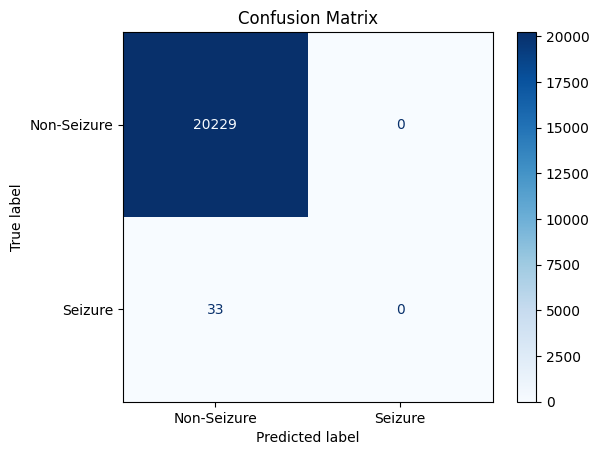

TN:  20229
FP:  0
FN:  33
TP:  0
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0052
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[[20229     1]
 [   12    20]]


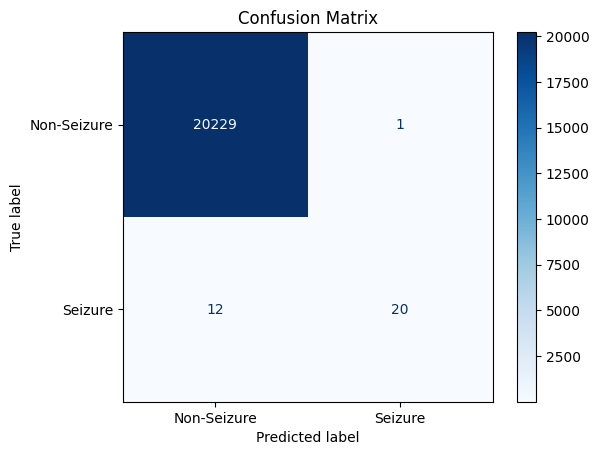

TN:  20229
FP:  1
FN:  12
TP:  20
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.0031
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
[[20234     1]
 [    8    18]]


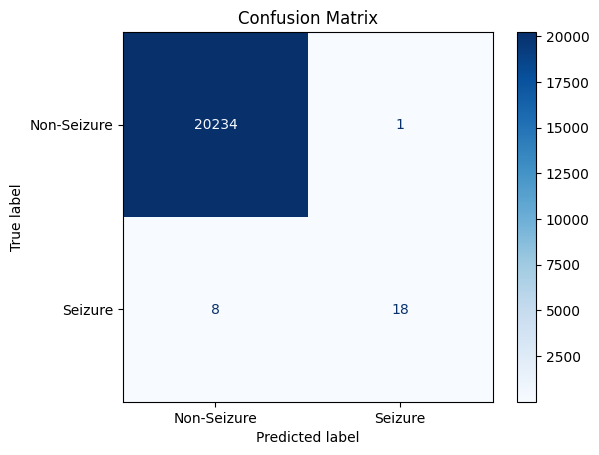

TN:  20234
FP:  1
FN:  8
TP:  18
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0029
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
[[20227     7]
 [    3    24]]


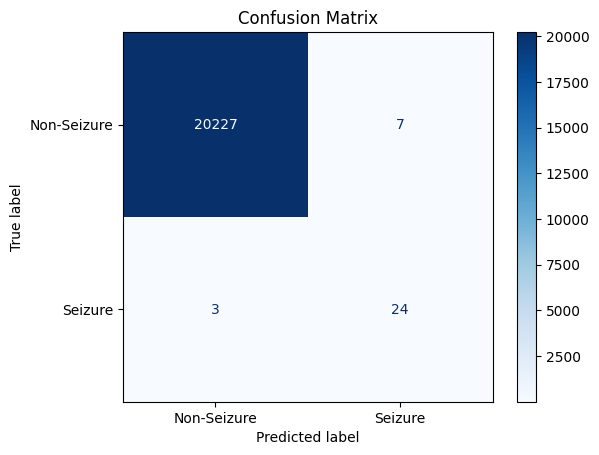

TN:  20227
FP:  7
FN:  3
TP:  24
3166/3166 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.0023
792/792 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
PCA_ANN
00:00:23.96
[[25267     8]
 [   12    40]]


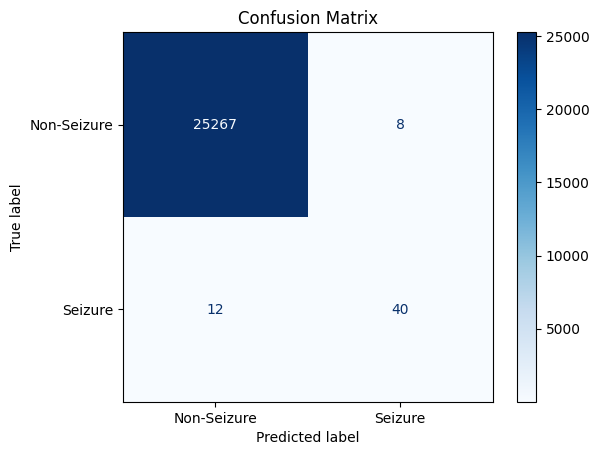

TN:  25267
FP:  8
FN:  12
TP:  40
     model  cv accuracy  cv recall  cv precision    cv FPR  cv f1 score  \
0  PCA_KNN     0.999852   0.911881      0.992308  0.000010     0.948845   
1  PCA_ANN     0.998993   0.441239           NaN  0.000089          NaN   

   test accuracy  test recall  test precision  test FPR  test f1 score  
0       0.999763     0.884615        1.000000  0.000000       0.938776  
1       0.999210     0.769231        0.833333  0.000317       0.800000  
**** Model Training is done. The result is in /content/drive/MyDrive/ELEC509/ELEC 509-Final Project Data/Results/chb02_results.csv ****

The number of samples for the non-seizure class is: 136464
The number of samples for the seizure class is: 465
Variables Kept after removing features with 0 variance:  506
Variables Kept after removing features with corr > 0.9:  505
The number of samples for the non-seizure class in training is: 109171
The number of samples for the seizure class in training is: 380
The number of sa

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[[21762     0]
 [    5    68]]


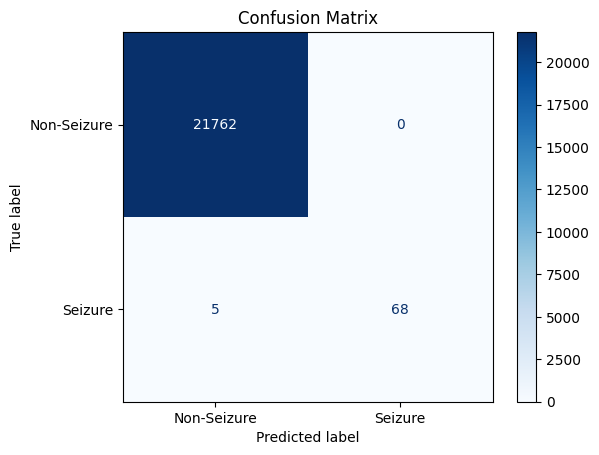

TN:  21762
FP:  0
FN:  5
TP:  68
[[21754     0]
 [    6    74]]


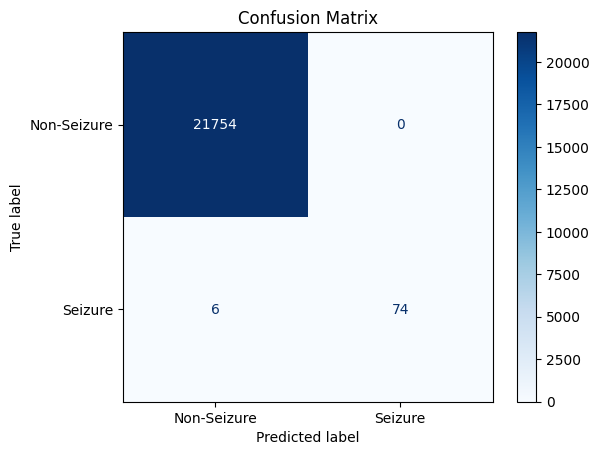

TN:  21754
FP:  0
FN:  6
TP:  74
[[21756     1]
 [    2    75]]


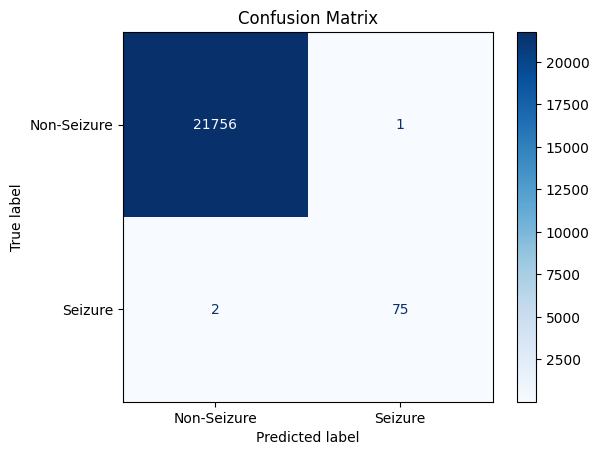

TN:  21756
FP:  1
FN:  2
TP:  75
[[21764     1]
 [    1    68]]


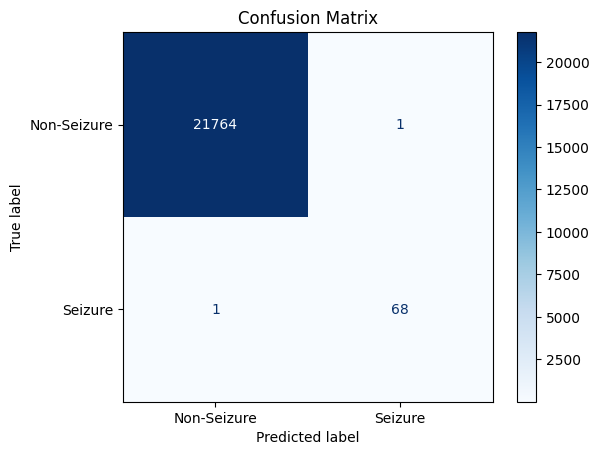

TN:  21764
FP:  1
FN:  1
TP:  68
[[21752     1]
 [    6    75]]


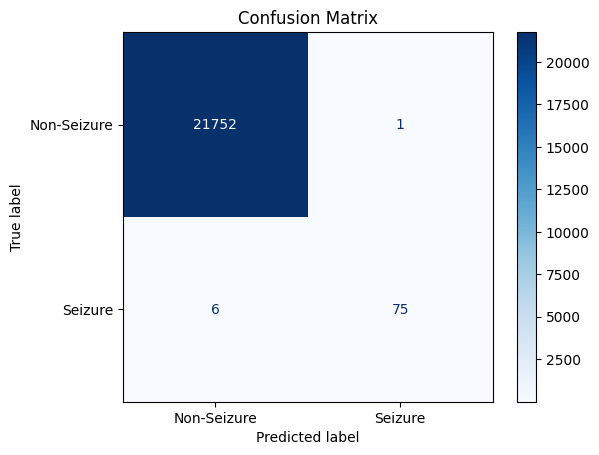

TN:  21752
FP:  1
FN:  6
TP:  75
PCA_KNN
00:02:05.82
[[27207     1]
 [    4    81]]


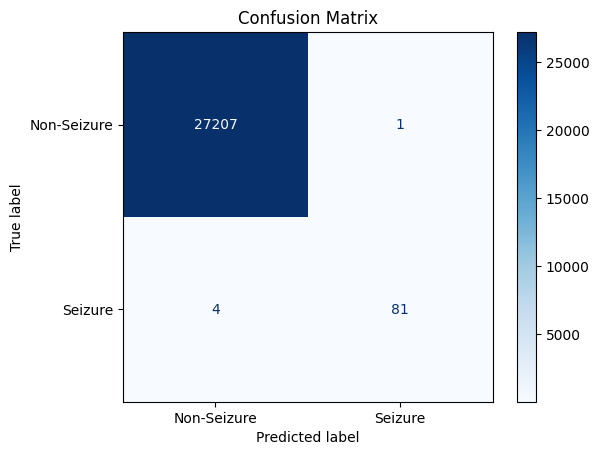

TN:  27207
FP:  1
FN:  4
TP:  81
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0374
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


<ipython-input-120-0985fa61fe7c>:88: RuntimeWarning: invalid value encountered in scalar divide
  precision.append(tp / (tp + fp))


[[21762     0]
 [   73     0]]


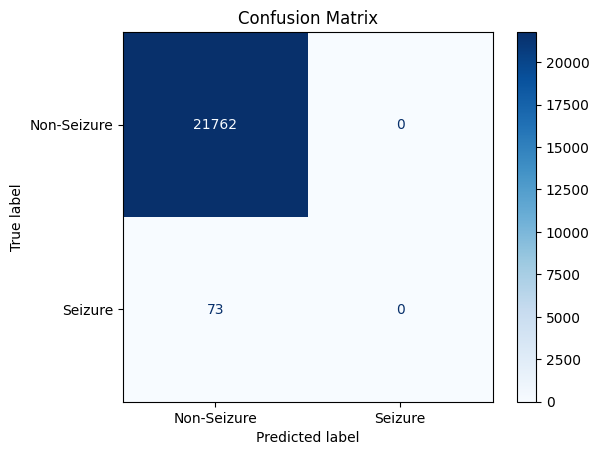

TN:  21762
FP:  0
FN:  73
TP:  0
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0104
683/683 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
[[21754     0]
 [   77     3]]


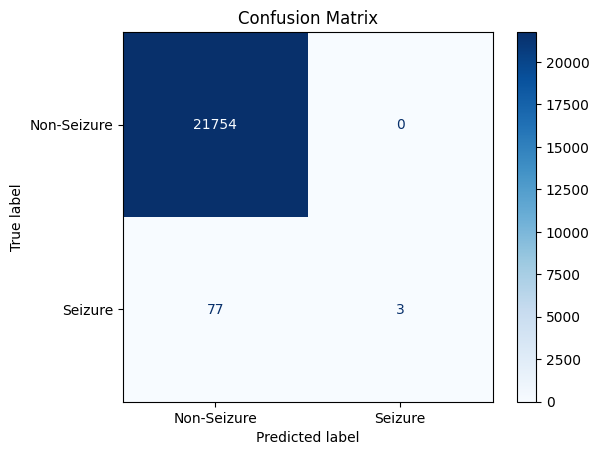

TN:  21754
FP:  0
FN:  77
TP:  3
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0071
683/683 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
[[21757     0]
 [   43    34]]


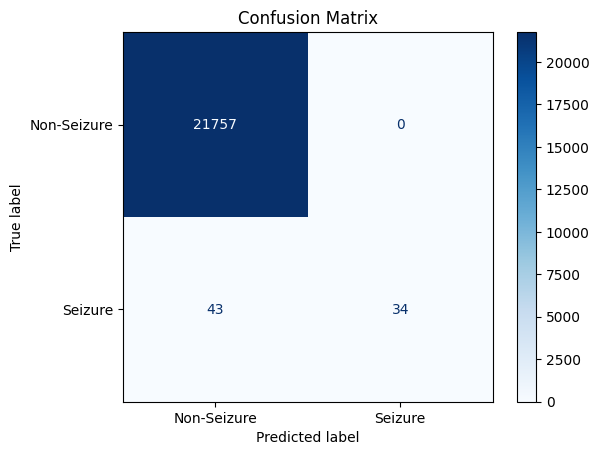

TN:  21757
FP:  0
FN:  43
TP:  34
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0056
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
[[21765     0]
 [   21    48]]


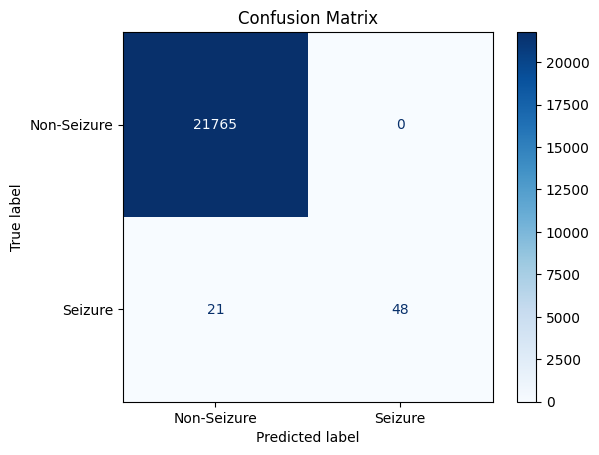

TN:  21765
FP:  0
FN:  21
TP:  48
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 0.0054
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
[[21752     1]
 [    8    73]]


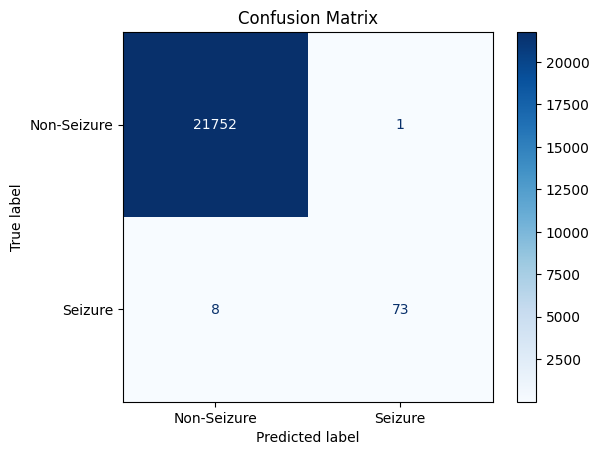

TN:  21752
FP:  1
FN:  8
TP:  73
3412/3412 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.0043
853/853 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
PCA_ANN
00:00:18.49
[[27203     5]
 [   15    70]]


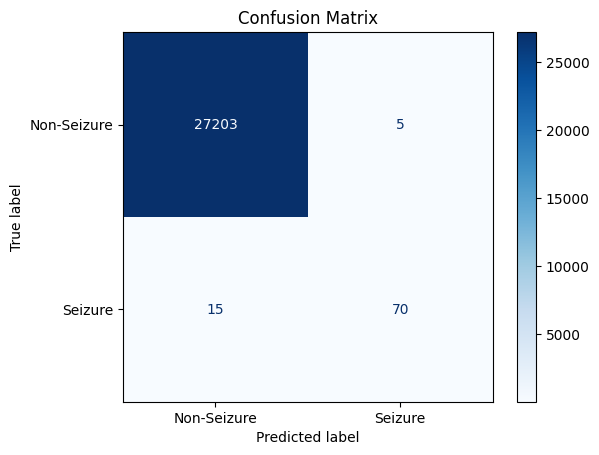

TN:  27203
FP:  5
FN:  15
TP:  70
     model  cv accuracy  cv recall  cv precision    cv FPR  cv f1 score  \
0  PCA_KNN     0.999789   0.948393      0.991838  0.000028     0.969378   
1  PCA_ANN     0.997957   0.415189           NaN  0.000009          NaN   

   test accuracy  test recall  test precision  test FPR  test f1 score  
0       0.999817     0.952941        0.987805  0.000037        0.97006  
1       0.999267     0.823529        0.933333  0.000184        0.87500  
**** Model Training is done. The result is in /content/drive/MyDrive/ELEC509/ELEC 509-Final Project Data/Results/chb03_results.csv ****

     model  cv accuracy  cv recall  cv precision    cv FPR  cv f1 score  \
0      KNN     0.998953   0.712444      0.981185  0.000043     0.824529   
1  PCA_KNN     0.998953   0.712444      0.981185  0.000043     0.824529   
2      ANN     0.997820   0.551755           NaN  0.000482          NaN   
3  PCA_ANN     0.998146   0.625554           NaN  0.000405          NaN   

   test 

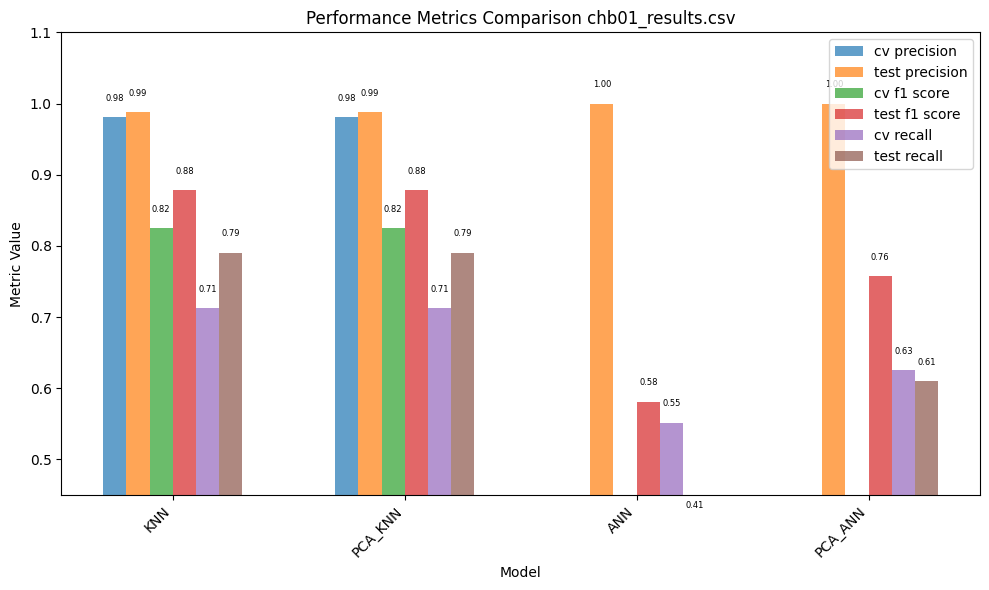

     model  cv accuracy  cv recall  cv precision    cv FPR  cv f1 score  \
0      KNN     0.999852   0.911881      0.992308  0.000010     0.948845   
1  PCA_KNN     0.999852   0.911881      0.992308  0.000010     0.948845   
2      ANN     0.998954   0.372293           NaN  0.000040          NaN   
3  PCA_ANN     0.998993   0.441239           NaN  0.000089          NaN   

   test accuracy  test recall  test precision  test FPR  test f1 score  
0       0.999763     0.884615        1.000000  0.000000       0.938776  
1       0.999763     0.884615        1.000000  0.000000       0.938776  
2       0.998934     0.865385        0.692308  0.000791       0.769231  
3       0.999210     0.769231        0.833333  0.000317       0.800000  


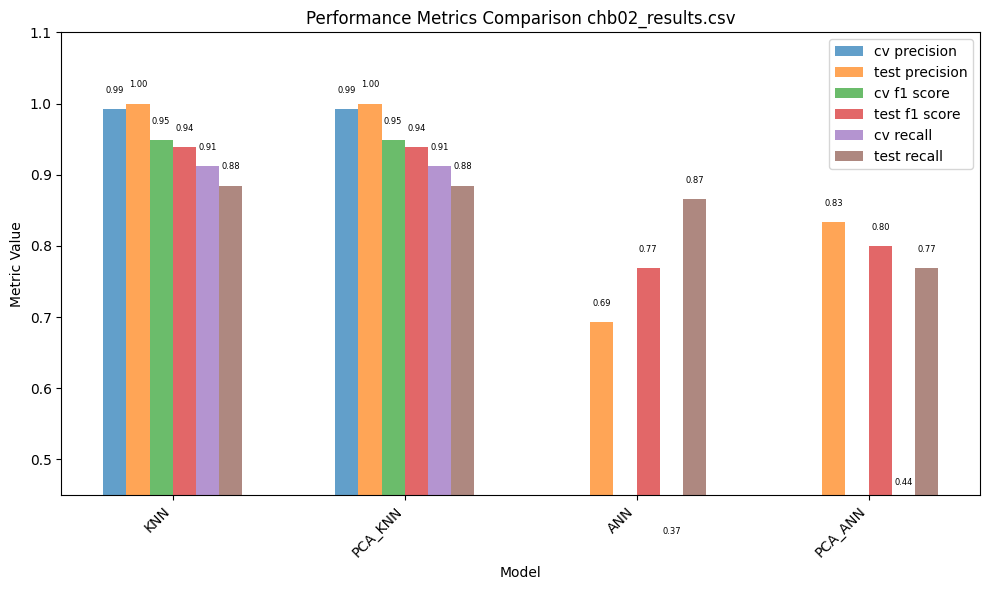

     model  cv accuracy  cv recall  cv precision    cv FPR  cv f1 score  \
0      KNN     0.999789   0.948393      0.991838  0.000028     0.969378   
1  PCA_KNN     0.999789   0.948393      0.991838  0.000028     0.969378   
2      ANN     0.998351   0.584688           NaN  0.000221          NaN   
3  PCA_ANN     0.997957   0.415189           NaN  0.000009          NaN   

   test accuracy  test recall  test precision  test FPR  test f1 score  
0       0.999817     0.952941        0.987805  0.000037       0.970060  
1       0.999817     0.952941        0.987805  0.000037       0.970060  
2       0.998095     0.388235        1.000000  0.000000       0.559322  
3       0.999267     0.823529        0.933333  0.000184       0.875000  


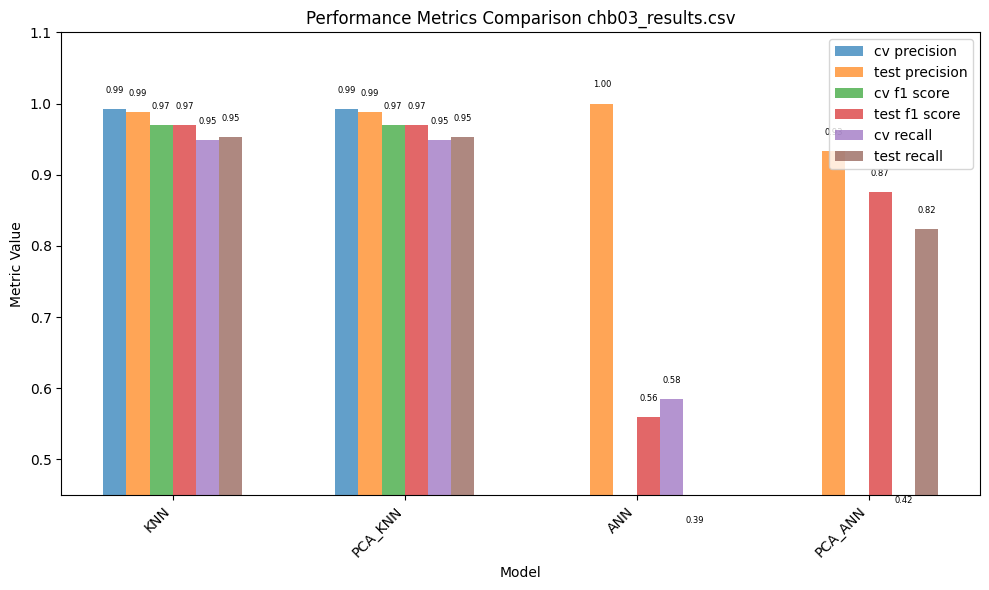

In [ ]:
def main():
  training()
  training(pca_flag = True)

  ### Make bar diagram

  file_path = '/content/drive/MyDrive/ELEC509/ELEC 509-Final Project Data/Results'  # Update file path if needed

  for file in os.listdir(file_path):
      # Construct the full file path
      full_file_path = os.path.join(file_path, file)

      # Read data from CSV file
      final = pd.read_csv(full_file_path)

      # Swap the first and second rows
      final.iloc[1], final.iloc[2] = final.iloc[2].copy(), final.iloc[1].copy()

      print(final)

      # Metrics you want to create bar diagrams for
      metrics_to_plot = ['cv precision', 'test precision', 'cv f1 score', 'test f1 score', 'cv recall', 'test recall']

      # Create a figure and axes
      fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed

      # Adjust y-axis scale
      ax.set_ylim([0.45, 1.1])  # Set the lower limit to 0.4 and the upper limit to 1.0

      # Bar width and positions
      bar_width = 0.1
      x_pos = np.arange(len(final['model']))  # X positions for models

      # Plot bars for each metric
      for i, metric in enumerate(metrics_to_plot):
          ax.bar(x_pos + i * bar_width, final[metric], width=bar_width, label=metric, alpha=0.7)

      # Set labels, title, and legend
      ax.set_xlabel('Model')
      ax.set_ylabel('Metric Value')
      ax.set_title(f'Performance Metrics Comparison {(file)}')
      ax.set_xticks(x_pos + bar_width * (len(metrics_to_plot) -1)/2)                # center the xticklabels
      ax.set_xticklabels(final['model'], rotation=45, ha='right')
      ax.legend()

      # Add values on top of the bars
      for i, metric in enumerate(metrics_to_plot):
          for j, val in enumerate(final[metric]):
              ax.text(x_pos[j] + i * bar_width, val + 0.02,                         # Adjust position as needed
                      f'{val:.2f}', ha='center', va='bottom', fontsize=6)           # Format value

      # Display the plot
      plt.tight_layout()
      plt.show()

if __name__ == "__main__":
  main()

In [ ]:
#Support Vector Machine (RBF)
from sklearn.svm import SVC
svm_rbf = SVC(kernel='rbf')

In [ ]:
#Support Vector Machine (Sigmoid)
svm_sig = SVC(kernel='sigmoid')

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()

In [ ]:
#Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()

In [ ]:
from sklearn.feature_selection import VarianceThreshold

def training2(pca_flag = False):

  # get all the subjects/patients' file information
  folder = r"/content/drive/MyDrive/ELEC 509-Final Project Data"
  #subjects = ["chb01"]
  #subjects = ["chb01", "chb02", "chb03"]

  training_csv_file_names_without_path = [file for file in os.listdir(folder) if file.endswith(".csv")]

  # get dataset file names prfixed with absolute path
  training_csv_files = [folder+'/'+file for file in os.listdir(folder) if file.endswith(".csv")]

  output_files = []

  print(f"{len(training_csv_files)} file(s) to be trained using the following models:\n{training_csv_files}")


  #for input_file, subject in zip(training_csv_files, subjects):
  for input_file, input_file_no_path in zip(training_csv_files, training_csv_file_names_without_path):
      # prepare data
      data = pd.read_csv(input_file)
      X = data.loc[:, data.columns != "seizure"]
      X = X.loc[:, X.columns != "start_time"]
      X = X.loc[:, X.columns != "file ID"]
      Y = np.asarray(data['seizure'])
      feature_names = X.columns.tolist()
      print('The number of samples for the non-seizure class is:', Y.shape[0])
      print('The number of samples for the seizure class is:', np.sum(Y))

      ### preprocessing

      # check zero variance features
      thresholder = VarianceThreshold(threshold=0)
      print("Variables Kept after removing features with 0 variance: ", thresholder.fit_transform(X).shape[1])

      # highly correlated features
      corr = abs(X.corr())
      upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
      cols = [column for column in upper.columns if any(upper[column] < 0.9)]
      print("Variables Kept after removing features with corr > 0.9: ", len(cols))

      # normalize features
      X = preprocessing.normalize(X)

      # split into testing and training
      X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)
      print('The number of samples for the non-seizure class in training is:', y_train.shape[0])
      print('The number of samples for the seizure class in training is:', np.sum(y_train))
      print('The number of samples for the non-seizure class in testing is:', y_test.shape[0])
      print('The number of samples for the seizure class in testing is:', np.sum(y_test))

      # PCA flag

      #if pca_flag == True:
          #PCA_process(X_train, X_test)

      #input_shape = X_train.shape[1]

      # Modeling
      #if pca_flag == True:
        #names = ["PCA_KNN", "PCA_ANN"]
      #else:
      names = ["SVM RBF", "SVM Sigmoid", "Random Forest", "Gradient Boost"]

      models = [
          svm_rbf, svm_sig, rf_model, gb_model
          ]

      result = []
      for name, model in zip(names, models):

          #if name == "ANN" or name == "PCA_ANN":
              #X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
              #X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
              #input_shape = X_train.shape[1]

          # cross validation
          kf = KFold(n_splits=5)
          accuracy, recall, FPR, precision, f1_score = [], [], [], [], []
          for train, test in kf.split(X_train):
              model.fit(X_train[train, :], y_train[train])
              pred = model.predict(X_train[test])
              if name == "ANN" or name == "PCA_ANN":
                  # Predict probabilities and convert to binary predictions
                  pred = (pred > 0.5).astype(int)                                   # Convert probabilities to 0 or 1
              tn, fp, fn, tp = confusion_matrix(y_train[test], pred).ravel()
              accuracy.append((tp + tn)/(tn + fp + fn + tp))
              precision.append(tp / (tp + fp))
              recall.append(tp / (tp + fn))                                         # True positive rate - recall
              FPR.append(fp / (fp + tn))                                            # False positive rate - probability of false alarm
              f1_score.append(2 * (precision[-1] * recall[-1]) / (precision[-1] + recall[-1]))
              print(confusion_matrix(y_train[test], pred))
              confusion_matrix_plot(y_train[test], pred)

          # test validation
          start = time.time()
          model.fit(X_train, y_train)
          pred = model.predict(X_test)
          #if name == "ANN" or name == "PCA_ANN":
              # Predict probabilities and convert to binary predictions
              #pred = (pred > 0.5).astype(int)                                        # Convert probabilities to 0 or 1
          tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
          test_accuracy = ((tp + tn)/(tn + fp + fn + tp))
          test_precision = (tp / (tp + fp))
          test_recall = (tp / (tp + fn))
          test_FPR = (fp / (fp + tn))
          test_f1_score = (2 * (test_precision * test_recall) / (test_precision + test_recall))
          end = time.time()
          hours, rem = divmod(end-start, 3600)
          minutes, seconds = divmod(rem, 60)
          print(name)
          print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
          print(confusion_matrix(y_test, pred))
          confusion_matrix_plot(y_test, pred)

          # record results
          result.append ({
                      'model': name,
                      'cv accuracy': mean(accuracy),
                      'cv recall': mean(recall),
                      'cv precision': mean(precision),
                      'cv FPR': mean(FPR),
                      'cv f1 score': mean(f1_score),
                      'test accuracy': test_accuracy,
                      'test recall': test_recall,
                      'test precision': test_precision,
                      'test FPR': test_FPR,
                      'test f1 score': test_f1_score
                  })

      final = pd.DataFrame.from_dict(result)

      output_file_name = input_file_no_path.replace(".csv", "_results.csv")

      subfolder_name = "Results2"
      output_file_folder_path = os.path.join(folder, subfolder_name)

      if not os.path.exists(output_file_folder_path):
        os.makedirs(output_file_folder_path)

      output_file = os.path.join(output_file_folder_path, output_file_name)
      final.to_csv(output_file, mode='a', index=False, header=False)

      print(final)
      print(f"**** Model Training is done. The result is in {output_file} ****\n")

          SVM RBF  0.9978023533079377  0.39767388635283085  \
0     SVM Sigmoid            0.996077             0.020041   
1  Gradient Boost            0.998532             0.731194   
2   Random Forest            0.999339             0.811721   

   0.9465319474926498  8.612597310499127e-05  0.5520782116138366  \
0            0.123770               0.000560            0.033568   
1            0.820164               0.000534            0.771264   
2            1.000000               0.000000            0.895473   

   0.9982830849529565  0.5333333333333333  0.9824561403508771  \
0            0.995708            0.028571            0.115385   
1            0.997425            0.742857            0.619048   
2            0.999107            0.761905            0.987654   

   3.4462556432436155e-05  0.691358024691358  
0                0.000793           0.045802  
1                0.001654           0.675325  
2                0.000034           0.860215  


KeyError: 'A'

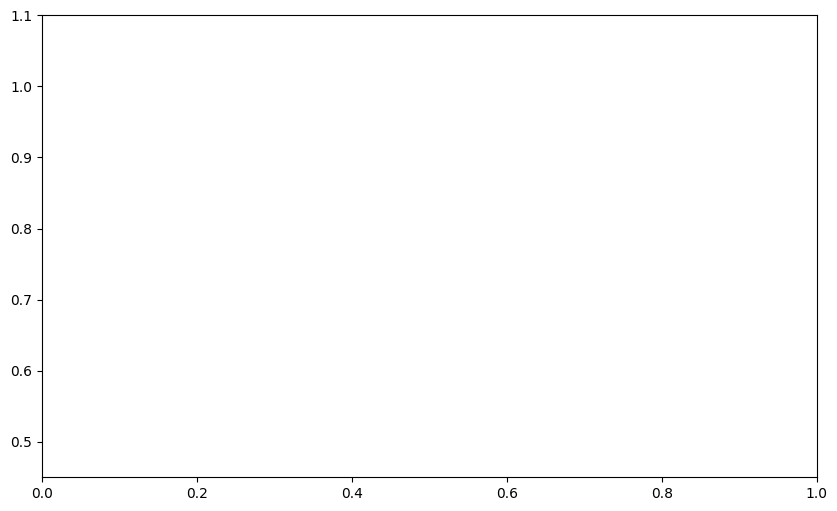

In [ ]:
def main2():
  training2()
  #training(pca_flag = True)

  ### Make bar diagram

  file_path = '/content/drive/MyDrive/ELEC 509-Final Project Data/Results2'  # Update file path if needed

  for file in os.listdir(file_path):
      # Construct the full file path
      full_file_path = os.path.join(file_path, file)

      # Read data from CSV file
      final = pd.read_csv(full_file_path)

      # Swap the first and second rows
      final.iloc[1], final.iloc[2] = final.iloc[2].copy(), final.iloc[1].copy()

      print(final)

      # Metrics you want to create bar diagrams for
      metrics_to_plot = ['cv precision', 'test precision', 'cv f1 score', 'test f1 score', 'cv recall', 'test recall']

      # Create a figure and axes
      fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed

      # Adjust y-axis scale
      ax.set_ylim([0.45, 1.1])  # Set the lower limit to 0.4 and the upper limit to 1.0

      # Bar width and positions
      bar_width = 0.1
      x_pos = np.arange(len(final['model']))  # X positions for models

      # Plot bars for each metric
      for i, metric in enumerate(metrics_to_plot):
          ax.bar(x_pos + i * bar_width, final[metric], width=bar_width, label=metric, alpha=0.7)

      # Set labels, title, and legend
      ax.set_xlabel('Model')
      ax.set_ylabel('Metric Value')
      ax.set_title(f'Performance Metrics Comparison {(file)}')
      ax.set_xticks(x_pos + bar_width * (len(metrics_to_plot) -1)/2)                # center the xticklabels
      ax.set_xticklabels(final['model'], rotation=45, ha='right')
      ax.legend()

      # Add values on top of the bars
      for i, metric in enumerate(metrics_to_plot):
          for j, val in enumerate(final[metric]):
              ax.text(x_pos[j] + i * bar_width, val + 0.02,                         # Adjust position as needed
                      f'{val:.2f}', ha='center', va='bottom', fontsize=6)           # Format value

      # Display the plot
      plt.tight_layout()
      plt.show()

if __name__ == "__main__":
  main2()